In [1]:
import json
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
import numpy as np
np.random.seed(0)

from tqdm import tqdm
import random

# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set_theme(style="white", palette="pastel")
import scipy
import json

from scipy import sparse

import time
import gc

from sklearn.manifold import TSNE

In [2]:
data_dir = '2022-06-02'

# colors = ['lightcoral','palegreen','skyblue','m','chocolate','orange']

papers = pd.read_csv(f'scibert_encoded_papers/valid_metadata_{data_dir}.csv',sep='\t').set_index('cord_uid')[['title','journal','publish_time']].sort_values('publish_time')

jrnls = Counter(papers['journal']).most_common(100)

# selected = [j[0] for j in jrnls]
selected = ['Br J Surg','Nat Commun'] # 'Int J Environ Res Public Health',
# selected = ['Int J Environ Res Public Health','Front Public Health','Br J Surg','Front Immunol','Int J Mol Sci','J Clin Med']
# selected = ['Int J Environ Res Public Health','Br J Surg','Int J Mol Sci']

In [3]:
n_per_class = 197
samples = []
for jrnl in selected:
    df = papers.loc[papers['journal']==jrnl].sample(n=n_per_class, random_state=0)
    samples.append(df)
samples = pd.concat(samples,axis=0)

samples['label'] = list(map(lambda x:selected.index(x),samples['journal'].tolist()))

In [4]:
models_embeddings = dict()

explained_variance_ratio_li =dict()
for method in ['tfidf','glove','scibert']:
    # SCIBERT Embedding
    if method == 'scibert':
        print('scibert')
        title_embs_df = pd.read_csv(f'scibert_encoded_papers/title_embs_df_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'scibert_encoded_papers/abstract_embs_df_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values
        pca = TruncatedSVD(n_components=512)
        X = pca.fit_transform(X)
        # print(pca.explained_variance_ratio_)
        explained_variance_ratio_li[method] = pca.explained_variance_ratio_
        X = X[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    # Glove Embedding
    if method == 'glove':
        print('glove')
        title_embs_df = pd.read_csv(f'title_embs_df_glove_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'abstract_embs_df_glove_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        # X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]
        X = paper_emb.values
        pca = TruncatedSVD(n_components=512)
        
        X = pca.fit_transform(X)
        # print(pca.explained_variance_ratio_)
        explained_variance_ratio_li[method] = pca.explained_variance_ratio_
        X = X[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    # TF-IDF Embedding
    if method == 'tfidf':
        print('tfidf')
        values = scipy.sparse.load_npz(f'tf-idf-results/values_{data_dir}_scibert_token.npz')
        index = json.load(open(f"tf-idf-results/index_{data_dir}_scibert_token",'r',encoding='utf-8'))
        column = json.load(open(f"tf-idf-results/column_{data_dir}_scibert_token",'r',encoding='utf-8'))
        # paper_emb = pd.DataFrame.sparse.from_spmatrix(values,columns=column,index=index)
        uid_map = {uid:i for i,uid in enumerate(index)}
        # X = values[list(map(lambda x:uid_map[x],samples.index.tolist()))]
        X = values
        pca = TruncatedSVD(n_components=512)
        X = pca.fit_transform(X)
        # print(pca.explained_variance_ratio_)
        explained_variance_ratio_li[method] = pca.explained_variance_ratio_

        X = X[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    models_embeddings[method] = X

tfidf
glove
scibert


In [11]:
# plt.plot([explained_variance_ratio_li['tfidf'][:i].sum() for i in range(100)], label='tfidf')
# plt.plot([explained_variance_ratio_li['glove'][:i].sum() for i in range(100)], label='glove')
# plt.plot([explained_variance_ratio_li['scibert'][:i].sum() for i in range(100)], label='scibert')
# plt.legend()

In [5]:
sample = np.arange(197)

In [13]:
explained_variance_ratio_li['tfidf'][:32].sum(), explained_variance_ratio_li['glove'][:32].sum(), explained_variance_ratio_li['scibert'][:32].sum()

(0.08846888754887733, 0.741063743529973, 0.6676192526437477)

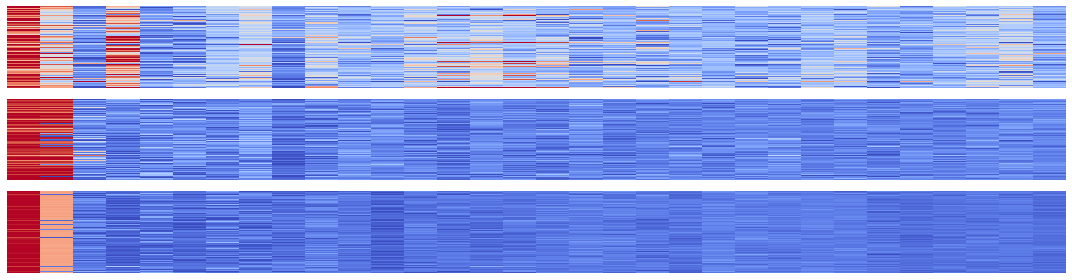

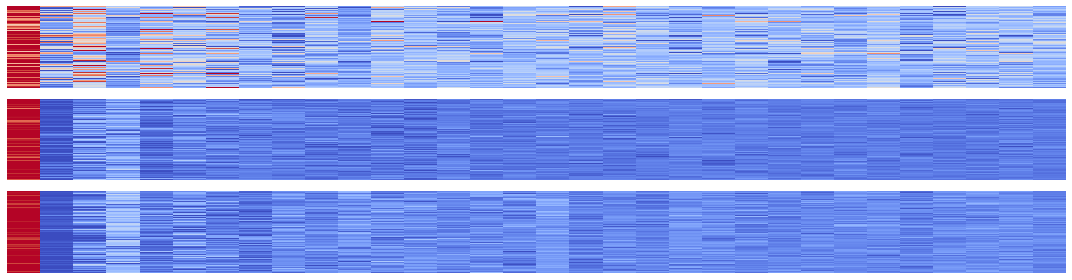

In [15]:
from collections import defaultdict


n_x = 32

cols = selected
rows = ['tfidf','glove','scibert']
pad = 5 # in points

std_dict = defaultdict(lambda:defaultdict(list))
# for ax, col in zip(axes[0], cols):
#     ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size='large', ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row.upper(), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')
for i in range(len(selected)):
#     print(selected[i])
    f, axes = plt.subplots(nrows=3, ncols=1 ,figsize = (15,2*len(selected)))
    for row, method in enumerate(['tfidf','glove','scibert']):
        
        df = pd.DataFrame(models_embeddings[method][samples['label'] == i][sample][:,:n_x])
        std_dict[method][i] = df.std(axis=0).tolist()
        # print()
        sns.heatmap(df, xticklabels=False,yticklabels=False,cbar=False, ax=axes[row], robust=True, cmap='coolwarm') 
    f.tight_layout()
    #f.savefig(f'Emb_Pattern_Subset_Scibert_{selected[i]}.svg')
# 查看标准差

pd.DataFrame(data=np.vstack(list(map(lambda x:np.array(x),pd.DataFrame(std_dict).loc[0].tolist()))),index=pd.DataFrame(std_dict).columns).T.to_csv('不归一化-journal-1-sample197.csv')
pd.DataFrame(data=np.vstack(list(map(lambda x:np.array(x),pd.DataFrame(std_dict).loc[1].tolist()))),index=pd.DataFrame(std_dict).columns).T.to_csv('不归一化-journal-2-sample197.csv')



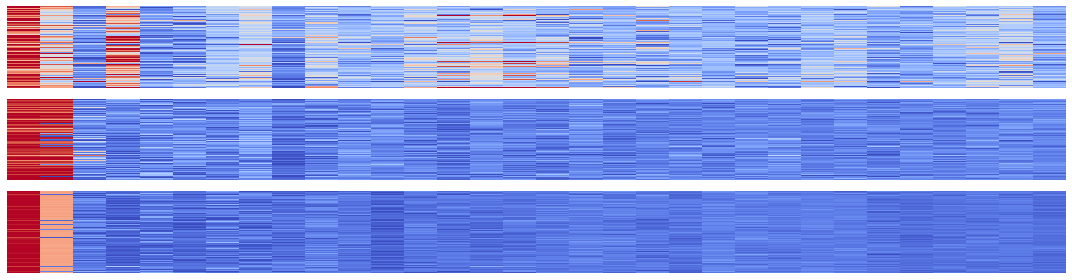

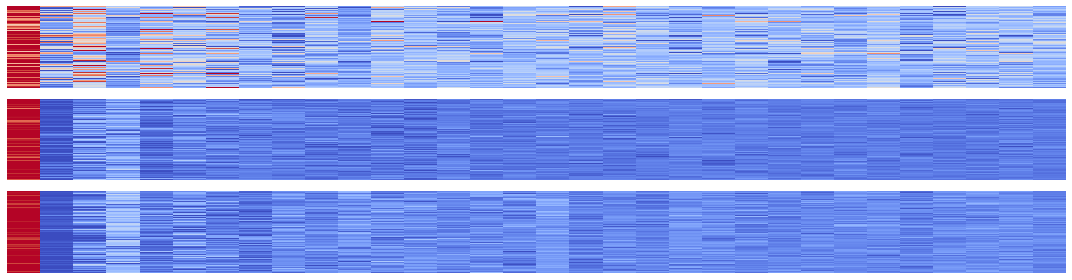

In [6]:
mean_ = np.average(models_embeddings['scibert'])
std_ = np.std(models_embeddings['scibert'])
models_embeddings['scibert'] = (models_embeddings['scibert']-mean_)/mean_

mean_ = np.average(models_embeddings['glove'])
std_ = np.std(models_embeddings['glove'])
models_embeddings['glove'] = (models_embeddings['glove']-mean_)/mean_

mean_ = np.average(models_embeddings['tfidf'])
std_ = np.std(models_embeddings['tfidf'])
models_embeddings['tfidf'] = (models_embeddings['tfidf']-mean_)/mean_

from collections import defaultdict


n_x = 32

cols = selected
rows = ['tfidf','glove','scibert']
pad = 5 # in points

std_dict = defaultdict(lambda:defaultdict(list))
# for ax, col in zip(axes[0], cols):
#     ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size='large', ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row.upper(), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')
for i in range(len(selected)):
#     print(selected[i])
    f, axes = plt.subplots(nrows=3, ncols=1 ,figsize = (15,2*len(selected)))
    for row, method in enumerate(['tfidf','glove','scibert']):
        
        df = pd.DataFrame(models_embeddings[method][samples['label'] == i][sample][:,:n_x])
        std_dict[method][i] = df.std(axis=0).tolist()
        # print()
        sns.heatmap(df, xticklabels=False,yticklabels=False,cbar=False, ax=axes[row], robust=True, cmap='coolwarm') 
    f.tight_layout()
    #f.savefig(f'Emb_Pattern_Subset_Scibert_{selected[i]}.svg')
# 查看标准差

pd.DataFrame(data=np.vstack(list(map(lambda x:np.array(x),pd.DataFrame(std_dict).loc[0].tolist()))),index=pd.DataFrame(std_dict).columns).T.to_csv('归一化-journal-1-sample197.csv')
pd.DataFrame(data=np.vstack(list(map(lambda x:np.array(x),pd.DataFrame(std_dict).loc[1].tolist()))),index=pd.DataFrame(std_dict).columns).T.to_csv('归一化-journal-2-sample197.csv')



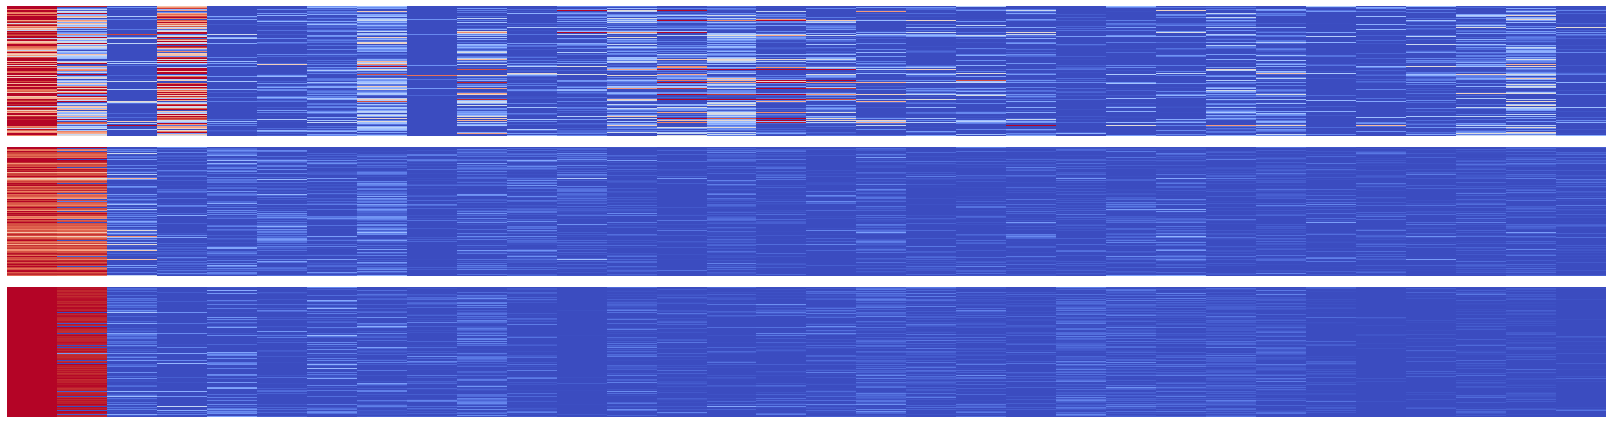

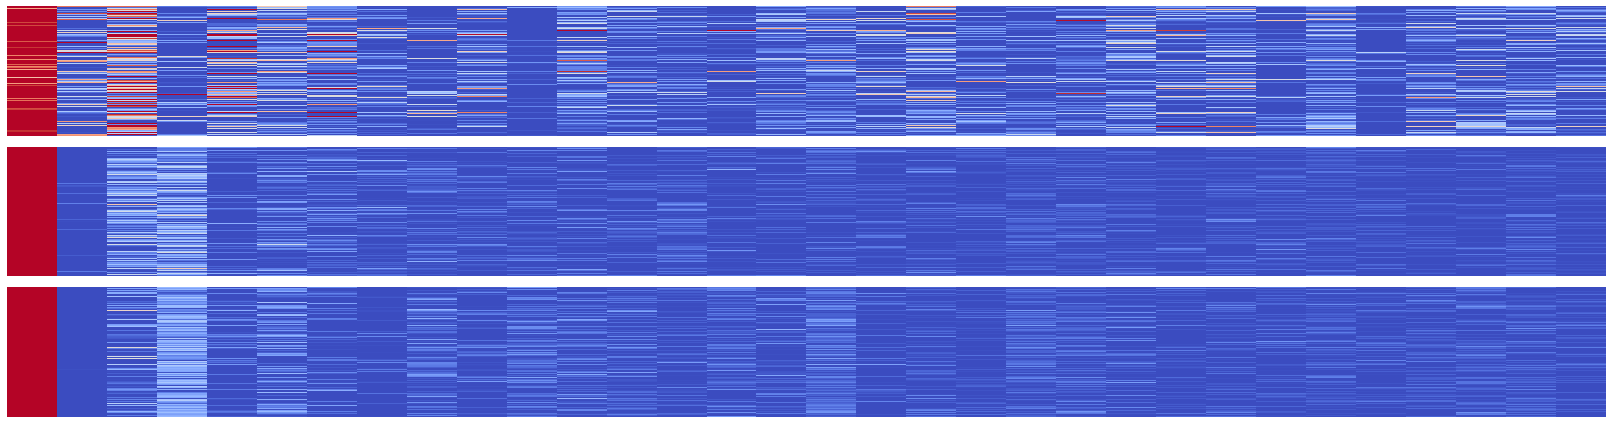

In [45]:
from collections import defaultdict


n_x = 32

cols = selected
rows = ['tfidf','glove','scibert']
pad = 5 # in points
maxx = 300
std_dict = defaultdict(lambda:defaultdict(list))
# for ax, col in zip(axes[0], cols):
#     ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size='large', ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row.upper(), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')
for i in range(len(selected)):
#     print(selected[i])
    f, axes = plt.subplots(nrows=3, ncols=1 ,figsize = (15*1.5,2*len(selected)*1.5))
    # cbar_ax = f.add_axes([.65, .83, .3, .06])

    for row, method in enumerate(['tfidf','glove','scibert']):
        
        df = pd.DataFrame(models_embeddings[method][samples['label'] == i][sample][:,:n_x])
        std_dict[method][i] = df.std(axis=0).tolist()
        # print()
        sns.heatmap(df, xticklabels=False,yticklabels=False,cbar=False, ax=axes[row], robust=True, cmap='coolwarm',vmin=0,vmax=maxx) 
    f.tight_layout()
    f.savefig(f'pattern/Emb_Pattern_Subset_Scibert_{selected[i]}-nocbar-max{maxx}.svg')